In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
os.environ["CPATH"]="/usr/local/cuda/include:$CPATH" #To use cuDNN

import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import bbknn

## Preprocessing of Liver reference data

In [3]:
adata = sc.read_h5ad('../../lotte_nb/anndatafineAnnot.h5ad')

In [6]:
adata.obs

,UMAP_1,UMAP_2,cluster,sample,type,citeSeq,digest,annot,combined,fine_annot,batch
cells,,,,,,,,,,,
AAACGAATCCACTTCG-2,0.761464,18.026580,4,CS48,RnaSeq,rnaSeq,Perfusion,Endothelial cells,1,LSECs,0
AAAGGTACAGGAAGTC-2,-3.941231,13.970400,2,CS48,RnaSeq,rnaSeq,Perfusion,Endothelial cells,1,LSECs,0
AACTTCTGTCATGGCC-2,-4.189379,14.684580,2,CS48,RnaSeq,rnaSeq,Perfusion,Endothelial cells,1,LSECs,0
AATGGCTCAACGGTAG-2,1.355759,17.638910,4,CS48,RnaSeq,rnaSeq,Perfusion,Endothelial cells,1,LSECs,0
ACACTGAAGTGCAGGT-2,-0.073541,18.127710,4,CS48,RnaSeq,rnaSeq,Perfusion,Endothelial cells,1,LSECs,0
...,...,...,...,...,...,...,...,...,...,...,...
TTCTTAGCACATAACC-46,7.300422,-5.189817,19,CS16,RnaSeq,rnaSeq,GentleMacs,Neutrophils,1,Neutrophils,1
TTGAACGAGTGAAGTT-46,5.629435,-6.119583,19,CS16,RnaSeq,rnaSeq,GentleMacs,Neutrophils,1,Neutrophils,1
TTGACTTTCCAATGGT-46,6.191045,-5.096178,19,CS16,RnaSeq,rnaSeq,GentleMacs,Neutrophils,1,Neutrophils,1


In [9]:
print("Coarse annotation:",adata.obs['annot'].cat.categories)
print("Fine annotation:",adata.obs['fine_annot'].cat.categories)

Coarse annotation: Index(['B cells', 'Basophils', 'Cholangiocytes', 'Endothelial cells',
       'Fibroblasts', 'Hepatocytes', 'HsPCs', 'ILC1s', 'Kupffer cells',
       'Mig. cDCs', 'Monocytes & Monocyte-derived cells', 'NK cells',
       'Neutrophils', 'T cells', 'cDC1s', 'cDC2s', 'pDCs'],
      dtype='object')
Fine annotation: Index(['B cells', 'Basophils', 'CD8 Effector Memory T cells', 'CTLs',
       'Capsular Fibroblasts', 'Central Vein Endothelial cells',
       'Cholangiocytes', 'Fibroblasts', 'Hepatocytes', 'HsPCs', 'ILC1s', 'KCs',
       'LSECs', 'Lymphatic Endothelial cells', 'Mesothelial cells',
       'Mig. cDCs', 'MoMac1', 'MoMac2', 'Monocytes', 'NK cells', 'NKT cells',
       'Naïve CD4+ T cells', 'Naïve CD8+ T cells', 'Neutrophils',
       'Patrolling Monocytes', 'Peritoneal Macrophages',
       'Portain Vein Endothelial cells', 'Stellate cells', 'TRegs', 'Th1s',
       'Th17 cells', 'Trans. Monocytes', 'Trans. Monocytes 2', 'cDC1s',
       'cDC2s', 'pDCs'],
      dtype='

In [11]:
adata.obs['type'].value_counts()

RnaSeq    167177
nucSeq     18662
Name: type, dtype: int64

In [12]:
# Logarithmize and normalize
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

In [13]:
# Calculate HVGs and PCA
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')

In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist = 0.8, spread = 1.5)

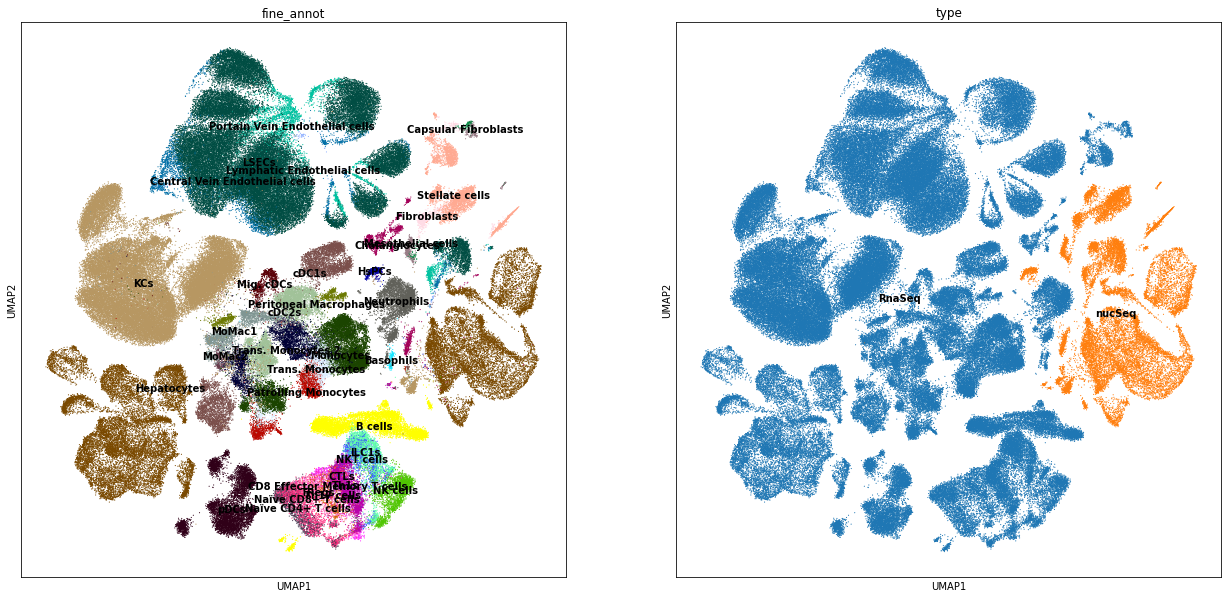

In [16]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata, color=['fine_annot', 'type'],
                size=5, legend_loc = 'on data')

In [22]:
# Running BBKNN
sc.external.pp.bbknn(adata, batch_key='type', metric='euclidean')
sc.tl.umap(adata)

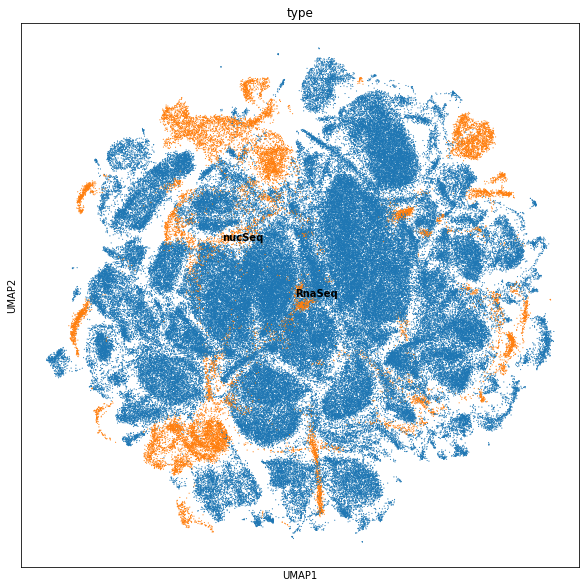

In [23]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata, color=['type'],
                size=5, legend_loc = 'on data')

## Extra - change colors of the text on the plot

In the thesis you might see that the labels on the UMAP are colored according to the region it is labeling. I could've done that manually in 20 minutes or so, but why do something manually in less than half an hour when you can automate it after five hours? (I spent a really long time figuring this out so I wanted to include it here.)

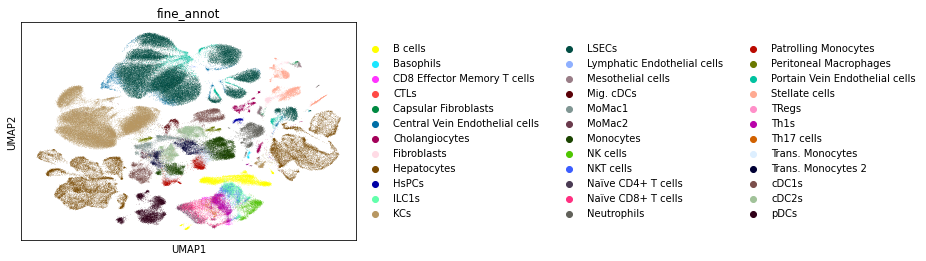

In [17]:
# First, you'll have to get the names and colors from another plot
ax = plt.subplot()
sc.pl.umap(adata, color=['fine_annot'],
           ax=ax, show=False)

handles, labels = ax.get_legend_handles_labels()
colors = [dot.get_facecolor().ravel() for dot in handles]

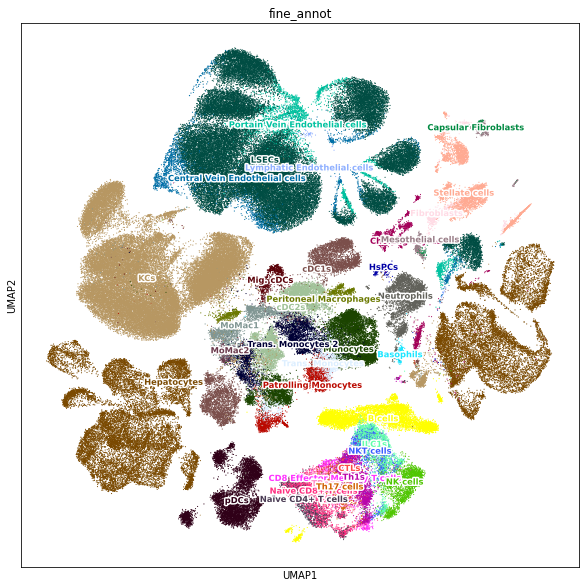

In [19]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    fig, ax = plt.subplots()
    sc.pl.umap(adata, color=['fine_annot'],
               legend_loc = 'on data', size = 5, legend_fontweight='semibold',
               legend_fontsize='small', legend_fontoutline=3, ax=ax,
               show=False)
    
    # This is where the magic happens
    i = 0
    # Get all elements of the plot, and check if it is a text
    for child in ax.get_children():
        if type(child) == mpl.text.Text:
            text = child.get_text()
            # If it is a text, change its color
            if text in labels:
                child.set_color(colors[i])
                i += 1

(Well, I ended up having to fix it up a bit in photoshop anyway.) The figure here is a little different because I used 40 PCs in the thesis, but the division is more or less the same. To keep the same coloring scheme I also exported these colors for use in R.

In [132]:
hex_colors = [mpl.colors.to_hex(c).upper() for c in colors]
print(hex_colors)

['#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#FFDBE5', '#7A4900', '#0000A6', '#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693', '#6A3A4C', '#1B4400', '#4FC601', '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A', '#BA0900', '#6B7900', '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA', '#D16100', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018']
